# Similarity calculation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

## Dataset Preprocessing (Paula's part)

Load the dataset that Raquel processed (joining a few different datasets and adding the sentiment analysis)

In [2]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete_og = main_complete.copy()
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [3]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [4]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We also did a small analysis of the genres to know with what we were working with

There are  19 different genres in the dataset
The genres are: {'Documentary', 'Fantasy', 'War', 'Adventure', 'Romance', 'Drama', 'Horror', 'History', 'Animation', 'Crime', 'Comedy', 'Thriller', 'Western', 'Action', 'Family', 'TV Movie', 'Science Fiction', 'Music', 'Mystery'}


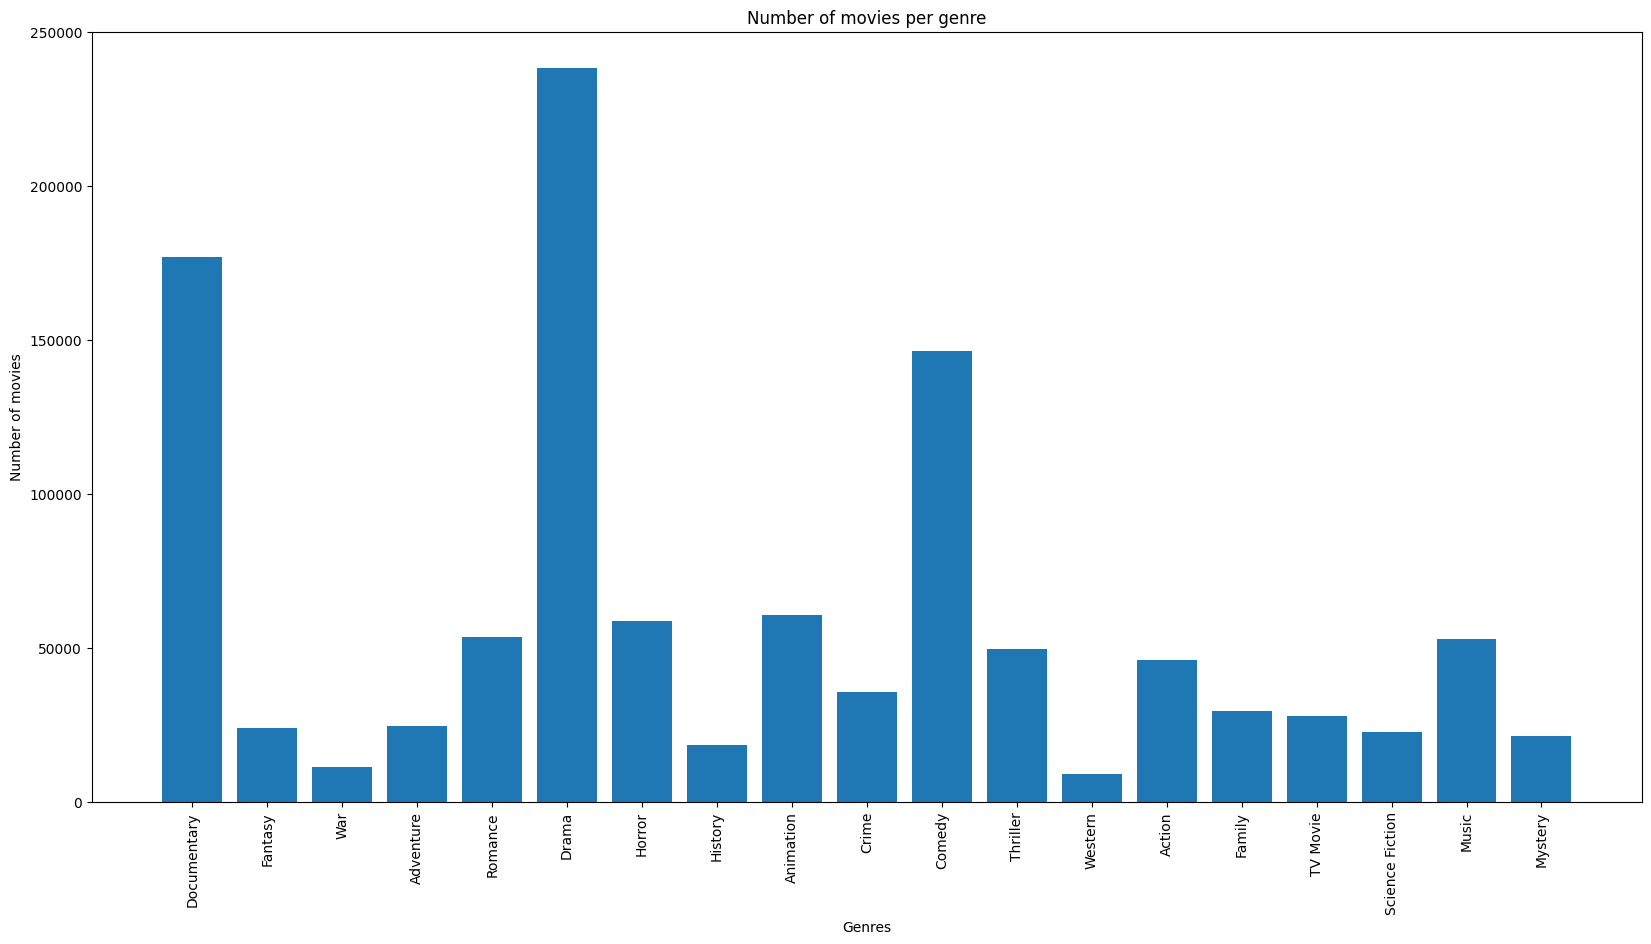

In [5]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We reproduced the same procedure that we did for the genres. In this case, for the crew, we joined the columns of director and producers.

In [6]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [7]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


After doing several tests with the code using different features, we decided to discard the 'cast' one because, since it is long, it has a big weight when calculating the similarities.

In [8]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

In [9]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [10]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was followed with these two features

In [11]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})

In [13]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [14]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [15]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment analysis

After calculating the sentiment for each movie, to take it into account for the minhashing, we decided to create three categories depending on the values. This was done due to the fact that dor this method, integers don't work as good as strings (TO REVIEW).

To find the thresholds we ...

In [16]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422418457 and median 85.76


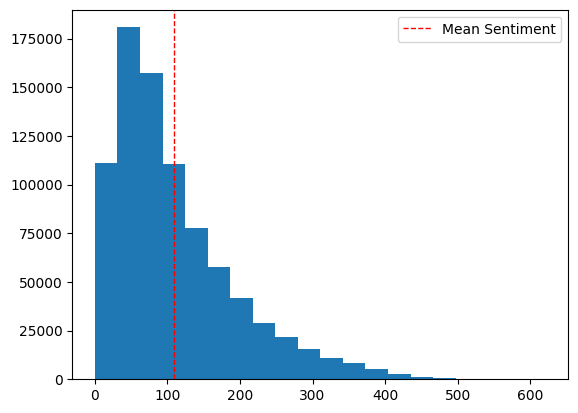

In [17]:
plt.hist(main_complete['sentiment'], bins=20)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

In [18]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Finally, before doing the minhashing, some movies were deleted from the dataset because they had more than 4 interested features empty and because they were not "Released".

In [20]:
# clean movies with 3 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [21]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %


Finally we saved the processed dataset so that we didn't have to run all the code everytime

## Minhashing

Load the small dataset that is the result of all the previous steps NOT SURE!!!
For some reason, when the dataset is loaded, the tokenization is lost and the similarity is not well calculated.

In [30]:
# prepare data for the minhashing, i just want to keep the columns: title, genre ones, sentiment, cast, crew, production_companies, production_countries and platform ones
data = main_complete[['id', 'title', 'genres', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO', 'crew', 'production_companies', 'production_countries', 'imdb_votes', 'imdb_rating']]

In [25]:
data = main_complete.copy()

In [ ]:
# load the small dataset
# data2 = pd.read_csv('data/small_main_complete.csv')

In [31]:
data.head()

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating
0,2,Ariel,"{Comedy, Crime, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4
1,3,Shadows in Paradise,"{Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Allison Anders, Alexandre Rockwell, Lawrence ...","{Miramax, A Band Apart}",{United States of America},112484.0,6.7
3,6,Judgment Night,"{Crime, Thriller, Action}",medium,0.0,1.0,0.0,0.0,0.0,"{Stephen Hopkins, Marilyn Vance, Lloyd Segan, ...","{Largo Entertainment, Universal Pictures, JVC}",{United States of America},19268.0,6.6
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2


Create the minhashes for each row

In [ ]:
# data2.head()

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating
0,2,Ariel,"{'Romance', 'Crime', 'Comedy', 'Drama'}",medium,0.0,1.0,1.0,0.0,0.0,{'Aki Kaurismäki'},{'Villealfa Filmproductions'},{'Finland'},8735.0,7.4
1,3,Shadows in Paradise,"{'Romance', 'Comedy', 'Drama'}",medium,0.0,1.0,1.0,0.0,0.0,"{'Mika Kaurismäki', 'Aki Kaurismäki'}",{'Villealfa Filmproductions'},{'Finland'},7484.0,7.5
2,5,Four Rooms,{'Comedy'},medium,0.0,1.0,0.0,1.0,0.0,"{'Robert Rodriguez', 'Alexandre Rockwell', 'Al...","{'Miramax', 'A Band Apart'}",{'United States of America'},112484.0,6.7
3,6,Judgment Night,"{'Crime', 'Action', 'Thriller'}",medium,0.0,1.0,0.0,0.0,0.0,"{'Marilyn Vance', 'Gene Levy', 'Stephen Hopkin...","{'JVC', 'Largo Entertainment', 'Universal Pict...",{'United States of America'},19268.0,6.6
4,8,Life in Loops (A Megacities RMX),{'Documentary'},high,0.0,0.0,0.0,0.0,0.0,"{'Ulrich Gehmacher', 'Timo Novotny'}",{'inLoops'},{'Austria'},284.0,8.2


In [32]:
# Number of permutations for MinHash
num_perm = 128

# Function to create a combined MinHash for a movie
def create_combined_minhash(movie, one_hot_features, non_one_hot_features):
    m = MinHash(num_perm=num_perm)
    
    # Add one-hot encoded features
    for feature in one_hot_features:
        if movie[feature] == 1:
            m.update(feature.encode('utf8'))
    
    # Add non-one-hot encoded features
    for feature in non_one_hot_features:
        for token in movie[feature]:
            m.update(token.encode('utf8'))
    
    return m

In [33]:
# list of one-hot encoded features
one_hot_features = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

# list of non-one-hot encoded features
non_one_hot_features = ['genres', 'sentiment_category', 'crew', 'production_companies', 'production_countries']

We create the minhashes taking into account the desired features

In [34]:
minhashes = []
for idx, movie in tqdm(data.iterrows(), total=len(data), desc="Creating MinHashes"):
    minhash = create_combined_minhash(movie, one_hot_features, non_one_hot_features)
    minhashes.append(minhash)

Creating MinHashes: 100%|██████████| 899275/899275 [10:32<00:00, 1421.10it/s]


In [37]:
data['minhash'] = minhashes
data.head()

/var/folders/x1/r0lcq37s2gv_b_dbmtl4lrx40000gn/T/ipykernel_8887/3287800951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minhash'] = minhashes


,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
0,2,Ariel,"{Comedy, Crime, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4,<datasketch.minhash.MinHash object at 0x41493e...
1,3,Shadows in Paradise,"{Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5,<datasketch.minhash.MinHash object at 0x41493e...
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Allison Anders, Alexandre Rockwell, Lawrence ...","{Miramax, A Band Apart}",{United States of America},112484.0,6.7,<datasketch.minhash.MinHash object at 0x41493e...
3,6,Judgment Night,"{Crime, Thriller, Action}",medium,0.0,1.0,0.0,0.0,0.0,"{Stephen Hopkins, Marilyn Vance, Lloyd Segan, ...","{Largo Entertainment, Universal Pictures, JVC}",{United States of America},19268.0,6.6,<datasketch.minhash.MinHash object at 0x41493e...
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2,<datasketch.minhash.MinHash object at 0x41493e...


In order to be computational efficient, a function that interacts with the user is created so that the program calculates the jaccard similarity of all the movies with the one inputed by the user. The result of this function is a list of the 10th more similar movies.

CHECK THE MOVIE_ID BECAUSE I THINK IT IS NOT WELL DONE

In [38]:
def estimate_jaccard_similarity(data, minhashes, movie_title):
    # Find all movies with the specified title
    matching_movies = data[data['title'] == movie_title]

    if len(matching_movies) > 1:
        print(f"There are multiple movies with the title '{movie_title}'. Please choose one by its id:")
        for idx, row in matching_movies.iterrows():
            print(f"ID: {row['id']}, Crew: {row['crew']}")
        movie_id = int(input("Enter the movie id: "))
        movie_index = data[data['id'] == movie_id].index[0]
        print(f"Selected movie with id '{movie_id}' in position '{movie_index}'")
    elif len(matching_movies) == 1:
        movie_index = data[data['title'] == movie_title].index[0]
        movie_id = data.iloc[movie_index]['id']
    else:
        print(f"No movies found with the title '{movie_title}'")
        return []

    # Estimate Jaccard similarity with the specified movie
    print(f"Estimated Jaccard Similarity with '{movie_title}':")
    similarity_scores = []

    for i in tqdm(range(len(minhashes)), desc="Calculating Similarities"):
        if i != movie_index:
            similarity = minhashes[movie_index].jaccard(minhashes[i])
            similarity_scores.append((data.iloc[i]['title'], similarity, minhashes[i], data.iloc[i]['id']))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    return similarity_scores, movie_id

In [39]:
# ask the user to input a movie title
movie_title = input("Enter a movie title: ")

print('The movie title that you entered is:', movie_title)
# estimate the Jaccard similarity with the specified movie
similarity_scores, movie_id = estimate_jaccard_similarity(data, minhashes, movie_title)

The movie title that you entered is: Star Wars
Estimated Jaccard Similarity with 'Star Wars':


Calculating Similarities: 100%|██████████| 899275/899275 [01:03<00:00, 14145.00it/s]


In [40]:
similarity_scores[:10]

[('The Empire Strikes Back',
  0.8515625,
  np.int64(1891)),
 ('Star Wars: Episode I - The Phantom Menace',
  0.828125,
  np.int64(1893)),
 ('Star Wars: Episode III - Revenge of the Sith',
  0.828125,
  np.int64(1895)),
 ('Star Wars: Episode II - Attack of the Clones',
  0.7578125,
  np.int64(1894)),
 ('Return of the Jedi',
  0.7265625,
  np.int64(1892)),
 ('Indiana Jones Epic Stunt Spectacular',
  0.625,
  np.int64(1374190)),
 ('Obi-wan Kenobi  - The Patterson Cut',
  0.59375,
  np.int64(1325386)),
 ('Indiana Jones and the Temple of the Forbidden Eye',
  0.5859375,
  np.int64(1374187)),
 ('Traveler',
  0.5703125,
  np.int64(521323)),
 ('Mad Max: A Wasteland Story',
  0.5546875,
  np.int64(340266))]

In [41]:
# Function to create a DataFrame with the top N similar movies
def create_top_n_dataframe(similarity_scores, data, movie_id, n=10):
    columns = ['title', 'crew', 'production_companies', 'production_countries', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']
    top_n_df = pd.DataFrame(columns=columns)
    top_n_list = []
    
    for movie, score, minhash, id in similarity_scores[:n]:
        movie_data = data[data['id'] == id]
        top_n_list.append(movie_data)

    top_n_list.append(data[data['id'] == movie_id])
    top_n_df = pd.concat(top_n_list)
    
    return top_n_df

# Create the DataFrame with the top 10 similar movies
top_10_df = create_top_n_dataframe(similarity_scores, data, movie_id, n=10)
top_10_df

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
1260,1891,The Empire Strikes Back,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,"{Rick McCallum, Howard G. Kazanjian, Irvin Ker...",{Lucasfilm Ltd.},{United States of America},1407106.0,8.7,<datasketch.minhash.MinHash object at 0x4242a7...
1262,1893,Star Wars: Episode I - The Phantom Menace,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,"{George Lucas, Rick McCallum}",{Lucasfilm Ltd.},{United States of America},874459.0,6.5,<datasketch.minhash.MinHash object at 0x4242a7...
1264,1895,Star Wars: Episode III - Revenge of the Sith,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,"{George Lucas, Rick McCallum}",{Lucasfilm Ltd.},{United States of America},861687.0,7.6,<datasketch.minhash.MinHash object at 0x4242ac...
1263,1894,Star Wars: Episode II - Attack of the Clones,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,"{George Lucas, Rick McCallum, Lorne Orleans}",{Lucasfilm Ltd.},{United States of America},773427.0,6.6,<datasketch.minhash.MinHash object at 0x4242ac...
1261,1892,Return of the Jedi,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,"{George Lucas, Rick McCallum, Howard G. Kazanj...",{Lucasfilm Ltd.},{United States of America},1141266.0,8.3,<datasketch.minhash.MinHash object at 0x4242a7...
1005285,1374190,Indiana Jones Epic Stunt Spectacular,"{Adventure, Action}",medium,0.0,0.0,0.0,0.0,0.0,{George Lucas},"{Lucasfilm Ltd., Industrial Light & Magic, Wal...",{United States of America},NaN,NaN,<datasketch.minhash.MinHash object at 0x4cbf84...
964252,1325386,Obi-wan Kenobi - The Patterson Cut,"{Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,{},{Lucasfilm Ltd.},{United States of America},NaN,NaN,<datasketch.minhash.MinHash object at 0x4c84b0...
1005282,1374187,Indiana Jones and the Temple of the Forbidden Eye,"{Adventure, Fantasy, Action}",medium,0.0,0.0,0.0,0.0,0.0,{George Lucas},"{Lucasfilm Ltd., Industrial Light & Magic, Wal...",{United States of America},NaN,NaN,<datasketch.minhash.MinHash object at 0x4cbf84...
362731,521323,Traveler,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,{Simon Brown},{Simon Brown},{United States of America},153.0,5.6,<datasketch.minhash.MinHash object at 0x1362d6...
218504,340266,Mad Max: A Wasteland Story,"{Adventure, Action, Science Fiction}",medium,0.0,0.0,0.0,0.0,0.0,{Paul C. Miller},{},{United States of America},NaN,NaN,<datasketch.minhash.MinHash object at 0x44c583...
